# Exploratory Data Analysis

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import datetime

## Our dataset

Let's load our base dataset, looking for interesting features

The dataset was collected with cyclist counters installed by Paris city council in multiple locations. It contains hourly information about cyclist traffic, as well as the following features,
 - counter name
 - counter site name
 - date
 - counter installation date
 - latitude and longitude
 
Available features are quite scarce. However, **we can also use any external data that can help us to predict the target variable.** 

In [2]:
data = pd.read_parquet("data/train.parquet")
data.head()

,counter_id,counter_name,site_id,site_name,bike_count,date,counter_installation_date,coordinates,counter_technical_id,latitude,longitude,log_bike_count
48321,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,0.0,2020-09-01 02:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,0.000000
48324,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,1.0,2020-09-01 03:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,0.693147
48327,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,0.0,2020-09-01 04:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,0.000000
48330,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,4.0,2020-09-01 15:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,1.609438
48333,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,9.0,2020-09-01 18:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,2.302585


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 496827 entries, 48321 to 929187
Data columns (total 12 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   counter_id                 496827 non-null  category      
 1   counter_name               496827 non-null  category      
 2   site_id                    496827 non-null  int64         
 3   site_name                  496827 non-null  category      
 4   bike_count                 496827 non-null  float64       
 5   date                       496827 non-null  datetime64[ns]
 6   counter_installation_date  496827 non-null  datetime64[ns]
 7   coordinates                496827 non-null  category      
 8   counter_technical_id       496827 non-null  category      
 9   latitude                   496827 non-null  float64       
 10  longitude                  496827 non-null  float64       
 11  log_bike_count             496827 non-null  floa

General description of our dataframe's features before proceeding further:
- Our data contains a variety of data types:
    - Some categorical variables such as counter_id, counter_name and site_id, site_name, and counter_technical_id, that give information about the concerned counter and its site.
    - We have two datetime objects: the date of the observation and the date of installation of the concerned counter.
    - We also have numerical data, such as the location data (including the longitude and latitude).

Let's divide the "date" information : 

In [4]:
def _encode_dates(X):
    X = X.copy()
    X["year"] = X["date"].dt.year
    X["month"] = X["date"].dt.month
    X["day"] = X["date"].dt.day
    X["weekday"] = X["date"].dt.weekday
    X["hour"] = X["date"].dt.hour
    return X

data = _encode_dates(data)

In [5]:
import holidays
vacances = holidays.CountryHoliday('France', years=[2020, 2021])
vacances_dates = pd.to_datetime(list(vacances.keys())).date

data["is_holiday"] = data["date"].isin(vacances_dates).astype(int)
data['is_weekend'] = data['weekday'].apply(lambda x: 1 if x >= 5 else 0)


Adding week-end and holidays with a binary variable for each:

## Visualizing the data


Let's visualize the data, starting from the spatial distribution of counters on the map

In [6]:
import folium

m = folium.Map(location=data[["latitude", "longitude"]].mean(axis=0), zoom_start=13)

for _, row in (
    data[["counter_name", "latitude", "longitude"]]
    .drop_duplicates("counter_name")
    .iterrows()
):
    folium.Marker(
        row[["latitude", "longitude"]].values.tolist(), popup=row["counter_name"]
    ).add_to(m)

m

In this challenge, we consider only the 30 most frequented counting sites, to limit data size.

Next we will look into the temporal distribution of the most frequented bike counter. If we plot it directly we will not see much because there are half a million data points:

# Temporal distribution

In this section, we analyze the data from the most frequented counter (S-N counter on Totem 73 Boulevard de Sebastopol) to uncover potential trends and patterns, as its high total bike count likely provides the most valuable insights. We begin by plotting the weekly total bike count.

<Axes: xlabel='date'>

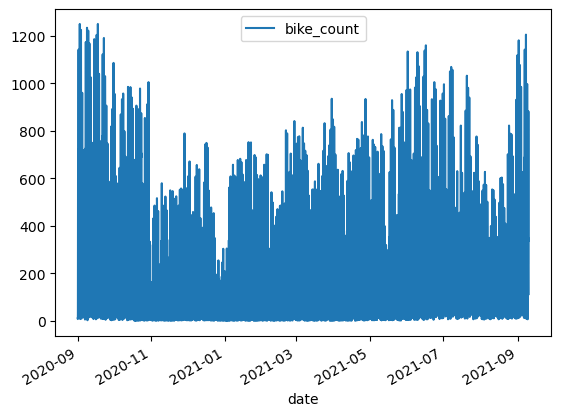

In [7]:
mask = data["counter_name"] == "Totem 73 boulevard de Sébastopol S-N"

data[mask].plot(x="date", y="bike_count")

Instead we aggregate the data, for instance, by week to have a clearer overall picture:

<Axes: xlabel='date'>

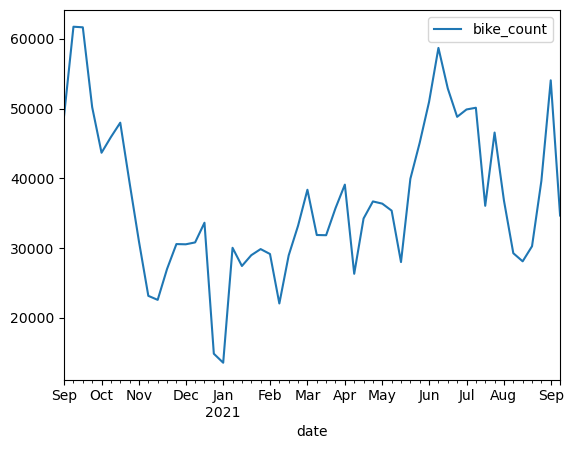

In [8]:
mask = (data["counter_name"] == "Totem 73 boulevard de Sébastopol S-N")

data[mask].groupby(
    pd.Grouper(freq="1w", key="date")
)[["bike_count"]].sum().plot()

As expected, we can notice a trend that formed during the year based on the month we're in: bike riding slowly decreases from September to December, to reach a minimum in January; It then gradually goes back up to rach a peak in June then decreases again in August and finally rises again in September.

From our observations, we can conclude that the bike_count is highly affected by the time of the year when we're taking our measurements, more specifically, it's dependent on the season we're in (and therefore on the weather conditions, which is why it is a great idea to insert precise weather data in our model with the aim of imporving its accuracy - which we'll do in the next part of this notebook): we notice that the two main troughs of the graphs we mentionned earlier happen in the months of November till February (approximately) and during the month of August which concide with winter and summer periods with extreme temperatures making it either too cold or too hot to ride a bike and therefore dropping the bike counts.**

While at the same time, we can zoom on a week in particular for a more short-term visualization,

<Axes: xlabel='date'>

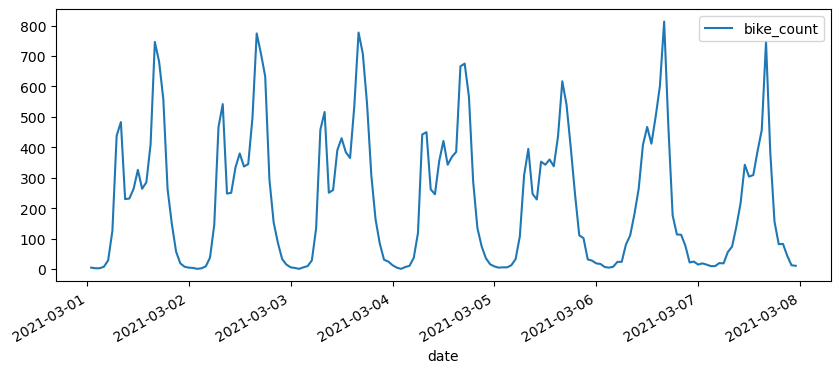

In [9]:
fig, ax = plt.subplots(figsize=(10, 4))

mask = (
    (data["counter_name"] == "Totem 73 boulevard de Sébastopol S-N")
    & (data["date"] > pd.to_datetime("2021/03/01"))
    & (data["date"] < pd.to_datetime("2021/03/08"))
)

data[mask].plot(x="date", y="bike_count", ax=ax)

The hourly pattern has a clear variation between work days and weekends (7 and 8 March 2021).



Let's ensure this difference by looking at the average on a week

<Figure size 1400x600 with 0 Axes>

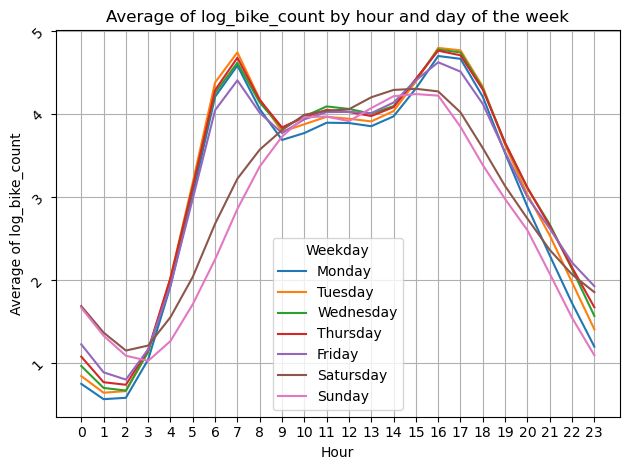

In [10]:
group1 = data.groupby(['weekday', 'hour'])['log_bike_count'].mean().unstack()

plt.figure(figsize=(14, 6))

group1.T.plot()

plt.title('Average of log_bike_count by hour and day of the week')
plt.xlabel('Hour')
plt.ylabel('Average of log_bike_count')
plt.xticks(range(0, 24))
plt.yticks(rotation=45)
plt.legend(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Satursday', 'Sunday'], title='Weekday')

plt.grid(True)
plt.tight_layout()
plt.show()


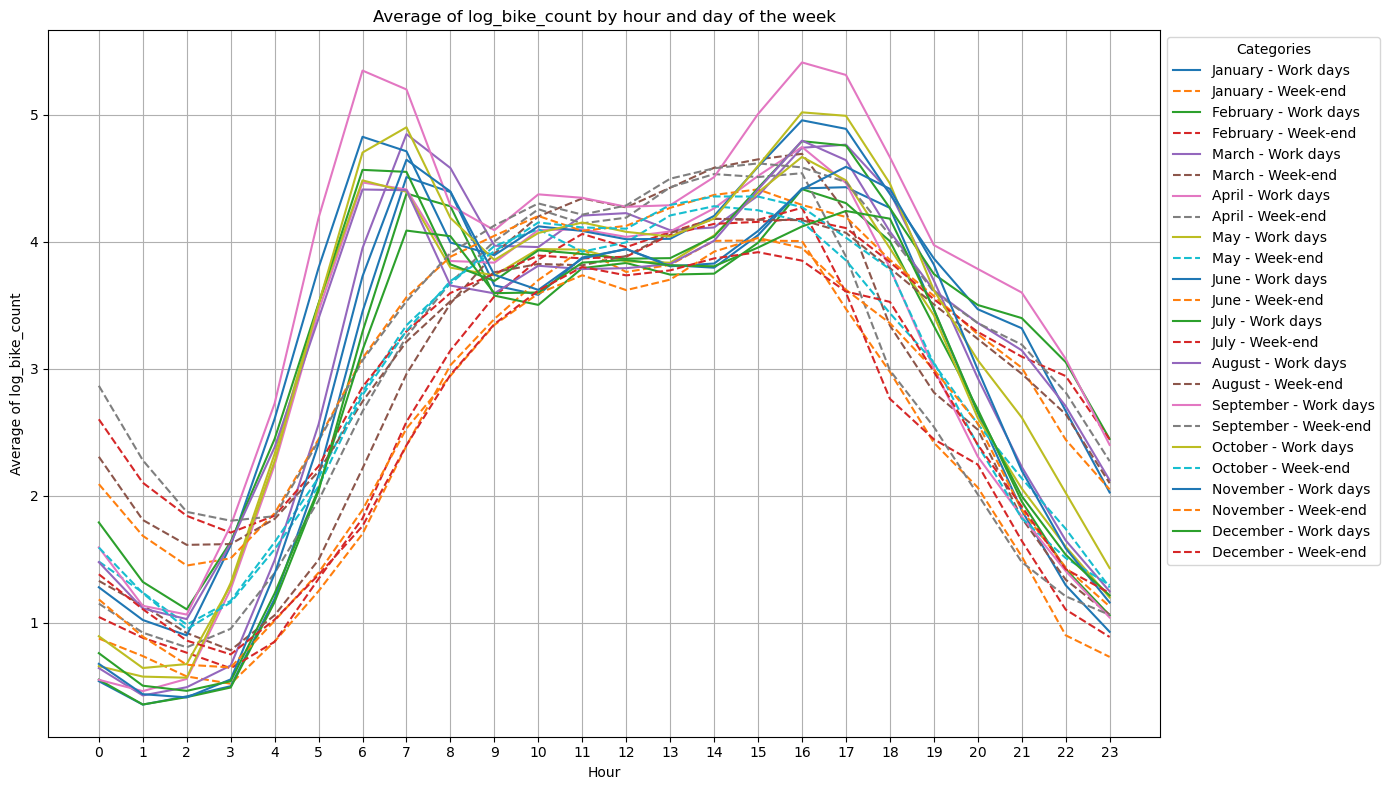

In [11]:
group2 = data.groupby(['month', 'is_weekend', 'hour'])['log_bike_count'].mean()

plt.figure(figsize=(14, 8))

months = ['January', 'February', 'March', 'April', 'May', 'June', 
          'July', 'August', 'September', 'October', 'November', 'December']

for month_index in range(1, 13):
    weekday_data = group2.loc[month_index, 0]
    weekend_data = group2.loc[month_index, 1]
    
    plt.plot(weekday_data.index, weekday_data.values, label=f'{months[month_index - 1]} - Work days')
    plt.plot(weekend_data.index, weekend_data.values, '--', label=f'{months[month_index - 1]} - Week-end')

plt.title('Average of log_bike_count by hour and day of the week')
plt.xlabel('Hour')
plt.ylabel('Average of log_bike_count')
plt.xticks(range(0, 24))
plt.legend(title='Categories', loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True)
plt.tight_layout()

plt.show()


This confirms that there is a clear difference between work days and week-end, so we will have to include this information in our model.

# Distribution study

If we look at the distribution of the target variable it skewed and non normal, 

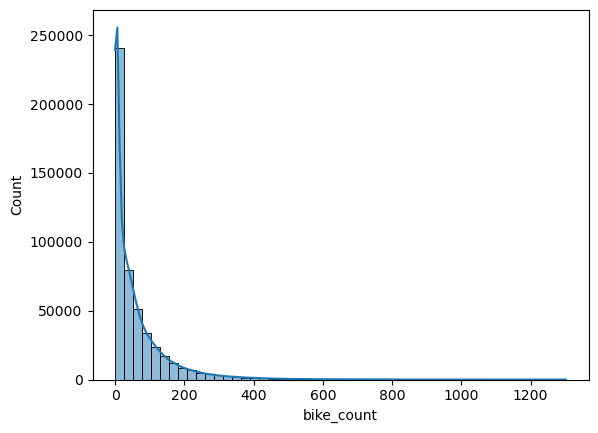

In [12]:
import seaborn as sns


ax = sns.histplot(data, x="bike_count", kde=True, bins=50)

Least square loss would not be appropriate to model it since it is designed for normal error distributions. One way to precede would be to transform the variable with a logarithmic transformation,
```py
data['log_bike_count'] = np.log(1 + data['bike_count'])
```

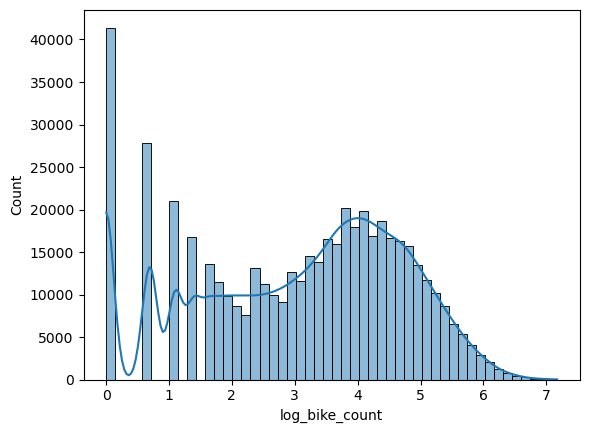

In [13]:
ax = sns.histplot(data, x="log_bike_count", kde=True, bins=50)

which has a more pronounced central mode, but is still non symmetric. In the following, **we use `log_bike_count` as the target variable** as otherwise `bike_count` ranges over 3 orders of magnitude and least square loss would be dominated by the few large values. 

In this section, we analyze the data from the most frequented counter (S-N counter on Totem 73 Boulevard de Sebastopol) to uncover potential trends and patterns, as its high total bike count likely provides the most valuable insights. We begin by plotting the weekly total bike count.

## Data cleaning

We decide to drop several columns including "counter_name", "site_name" and other as they refer to a unique counter the same way "counter_id" does. Therefore, these columns do not bring any information. Also, we drop "bike_count" as we are only interested in "log_bike_count"

In [14]:
columns_to_drop_bike = [
    "site_id",
    "counter_name",
    "site_name",
    "bike_count",
    "counter_installation_date",
    "counter_technical_id",
]
data = data.drop(columns=columns_to_drop_bike)

##  Weather data analysis

Let's load our weather dataset, looking for interesting features

In [15]:
weather = pd.read_csv('data/external_data.csv')
weather.head()

,numer_sta,date,pmer,tend,cod_tend,dd,ff,t,td,u,...,hnuage1,nnuage2,ctype2,hnuage2,nnuage3,ctype3,hnuage3,nnuage4,ctype4,hnuage4
0,7149,2021-01-01 00:00:00,100810,80,1,270,1.8,272.75,272.15,96,...,600.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,7149,2021-01-01 03:00:00,100920,110,3,300,1.7,271.25,270.95,98,...,1500.0,2.0,3.0,3000.0,NaN,NaN,NaN,NaN,NaN,NaN
2,7149,2021-01-01 06:00:00,100950,30,3,290,2.6,271.95,271.65,98,...,480.0,4.0,6.0,2000.0,6.0,3.0,3000.0,NaN,NaN,NaN
3,7149,2021-01-01 09:00:00,101100,150,2,280,1.7,272.45,272.05,97,...,1740.0,3.0,3.0,2800.0,NaN,NaN,NaN,NaN,NaN,NaN
4,7149,2021-01-01 12:00:00,101110,30,0,50,1.0,276.95,274.15,82,...,330.0,4.0,6.0,570.0,7.0,6.0,810.0,NaN,NaN,NaN


We can see that a lot of collumn have NaN values. We have to decide wheter we drop the whole column or we drop only the rows with NaN values, if there is only a few ones.

Let's see what are the main columns to drop

In [16]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3322 entries, 0 to 3321
Data columns (total 59 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   numer_sta  3322 non-null   int64  
 1   date       3322 non-null   object 
 2   pmer       3322 non-null   int64  
 3   tend       3322 non-null   int64  
 4   cod_tend   3322 non-null   int64  
 5   dd         3322 non-null   int64  
 6   ff         3322 non-null   float64
 7   t          3322 non-null   float64
 8   td         3322 non-null   float64
 9   u          3322 non-null   int64  
 10  vv         3322 non-null   int64  
 11  ww         3322 non-null   int64  
 12  w1         3315 non-null   float64
 13  w2         3312 non-null   float64
 14  n          3166 non-null   float64
 15  nbas       3317 non-null   float64
 16  hbas       2869 non-null   float64
 17  cl         2909 non-null   float64
 18  cm         1941 non-null   float64
 19  ch         1678 non-null   float64
 20  pres    

In [17]:
weather.isna().sum().sort_values(ascending=False)

sw           3322
niv_bar      3322
phenspe4     3322
phenspe3     3322
phenspe2     3322
phenspe1     3322
tw           3322
tx24         3322
tn24         3322
geop         3322
tminsol      3321
nnuage4      3280
hnuage4      3280
ctype4       3235
ctype3       2852
hnuage3      2704
nnuage3      2704
tn12         2492
tx12         2492
ctype2       1879
ch           1644
hnuage2      1627
nnuage2      1627
cm           1381
ctype1        798
hnuage1       455
hbas          453
nnuage1       449
ssfrai        445
perssfrai     445
cl            413
n             156
etat_sol       52
ht_neige       49
rr24           24
rr12           22
rr6            16
w2             10
raf10          10
tend24         10
rr1             9
w1              7
rr3             6
nbas            5
u               0
pmer            0
pres            0
ww              0
vv              0
date            0
td              0
t               0
tend            0
cod_tend        0
dd              0
ff        

We define a treshold $\alpha$ to decide wether we drop the column or the row

In [18]:
alpha = 1

null_percentages = (weather.isnull().sum() / len(weather)) * 100
columns_to_drop_weather = (list(null_percentages[null_percentages > alpha].index))
weather = weather.drop(columns = list(columns_to_drop_weather))
weather


,numer_sta,date,pmer,tend,cod_tend,dd,ff,t,td,u,...,pres,tend24,raf10,rafper,per,rr1,rr3,rr6,rr12,rr24
0,7149,2021-01-01 00:00:00,100810,80,1,270,1.8,272.75,272.15,96,...,99680,470.0,2.5,2.5,-10,0.0,0.0,0.0,0.0,2.0
1,7149,2021-01-01 03:00:00,100920,110,3,300,1.7,271.25,270.95,98,...,99790,750.0,2.2,2.2,-10,0.0,0.0,0.0,0.0,1.2
2,7149,2021-01-01 06:00:00,100950,30,3,290,2.6,271.95,271.65,98,...,99820,900.0,3.2,3.2,-10,0.0,0.0,0.0,0.0,1.0
3,7149,2021-01-01 09:00:00,101100,150,2,280,1.7,272.45,272.05,97,...,99970,860.0,2.3,2.3,-10,0.0,0.2,0.2,0.2,0.2
4,7149,2021-01-01 12:00:00,101110,30,0,50,1.0,276.95,274.15,82,...,100000,790.0,2.5,4.4,-10,0.0,0.0,0.2,0.2,0.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3317,7149,2020-09-30 09:00:00,101540,-30,8,230,4.4,289.95,286.85,82,...,100480,-330.0,7.1,7.1,-10,0.0,0.0,0.0,0.0,2.2
3318,7149,2020-09-30 12:00:00,101320,-210,8,190,4.9,292.05,285.55,66,...,100270,-560.0,7.2,7.2,-10,0.0,0.2,0.2,0.2,1.6
3319,7149,2020-09-30 15:00:00,101140,-180,7,190,4.1,291.55,286.45,72,...,100090,-650.0,6.4,8.4,-10,0.0,0.0,0.2,0.2,0.2
3320,7149,2020-09-30 18:00:00,101020,-130,6,190,2.7,290.15,285.25,73,...,99960,-790.0,4.3,5.2,-10,0.0,0.0,0.0,0.2,0.2


In [19]:
null_percentages = (weather.isnull().sum() / len(weather)) * 100
rows_to_delete = null_percentages[null_percentages <= alpha]
weather = weather.dropna(subset=list(rows_to_delete.index))
weather

,numer_sta,date,pmer,tend,cod_tend,dd,ff,t,td,u,...,pres,tend24,raf10,rafper,per,rr1,rr3,rr6,rr12,rr24
0,7149,2021-01-01 00:00:00,100810,80,1,270,1.8,272.75,272.15,96,...,99680,470.0,2.5,2.5,-10,0.0,0.0,0.0,0.0,2.0
1,7149,2021-01-01 03:00:00,100920,110,3,300,1.7,271.25,270.95,98,...,99790,750.0,2.2,2.2,-10,0.0,0.0,0.0,0.0,1.2
2,7149,2021-01-01 06:00:00,100950,30,3,290,2.6,271.95,271.65,98,...,99820,900.0,3.2,3.2,-10,0.0,0.0,0.0,0.0,1.0
3,7149,2021-01-01 09:00:00,101100,150,2,280,1.7,272.45,272.05,97,...,99970,860.0,2.3,2.3,-10,0.0,0.2,0.2,0.2,0.2
4,7149,2021-01-01 12:00:00,101110,30,0,50,1.0,276.95,274.15,82,...,100000,790.0,2.5,4.4,-10,0.0,0.0,0.2,0.2,0.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3317,7149,2020-09-30 09:00:00,101540,-30,8,230,4.4,289.95,286.85,82,...,100480,-330.0,7.1,7.1,-10,0.0,0.0,0.0,0.0,2.2
3318,7149,2020-09-30 12:00:00,101320,-210,8,190,4.9,292.05,285.55,66,...,100270,-560.0,7.2,7.2,-10,0.0,0.2,0.2,0.2,1.6
3319,7149,2020-09-30 15:00:00,101140,-180,7,190,4.1,291.55,286.45,72,...,100090,-650.0,6.4,8.4,-10,0.0,0.0,0.2,0.2,0.2
3320,7149,2020-09-30 18:00:00,101020,-130,6,190,2.7,290.15,285.25,73,...,99960,-790.0,4.3,5.2,-10,0.0,0.0,0.0,0.2,0.2


## Merging data

In [20]:
weather['date'] = pd.to_datetime(weather['date'], format='%Y-%m-%d %H:%M:%S')
weather = weather.sort_values(by='date', ascending=True)

/var/folders/48/xwb303h13cj206r81_rrqr840000gn/T/ipykernel_17519/493761102.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weather['date'] = pd.to_datetime(weather['date'], format='%Y-%m-%d %H:%M:%S')


In [21]:
data = data.sort_values(by='date', ascending=True)
data = pd.merge_asof(data, weather, on='date', direction='nearest')

In [22]:
data.head()

,counter_id,date,coordinates,latitude,longitude,log_bike_count,year,month,day,weekday,...,pres,tend24,raf10,rafper,per,rr1,rr3,rr6,rr12,rr24
0,100007049-101007049,2020-09-01 01:00:00,"48.846028,2.375429",48.846028,2.375429,0.693147,2020,9,1,1,...,100960,120.0,2.4,3.1,-10,0.0,0.0,0.0,0.0,0.0
1,100056226-103056226,2020-09-01 01:00:00,"48.830331,2.400551",48.830331,2.400551,0.693147,2020,9,1,1,...,100960,120.0,2.4,3.1,-10,0.0,0.0,0.0,0.0,0.0
2,100047545-104047545,2020-09-01 01:00:00,"48.890457,2.368852",48.890457,2.368852,0.693147,2020,9,1,1,...,100960,120.0,2.4,3.1,-10,0.0,0.0,0.0,0.0,0.0
3,100060178-102060178,2020-09-01 01:00:00,"48.84638,2.31529",48.846380,2.315290,3.091042,2020,9,1,1,...,100960,120.0,2.4,3.1,-10,0.0,0.0,0.0,0.0,0.0
4,100056327-103056327,2020-09-01 01:00:00,"48.86461,2.40969",48.864610,2.409690,1.098612,2020,9,1,1,...,100960,120.0,2.4,3.1,-10,0.0,0.0,0.0,0.0,0.0


# Correlation analysis

Let's see (naively) if there is a linear correlation between our variables, "especially with log_by_count" : 

<Axes: >

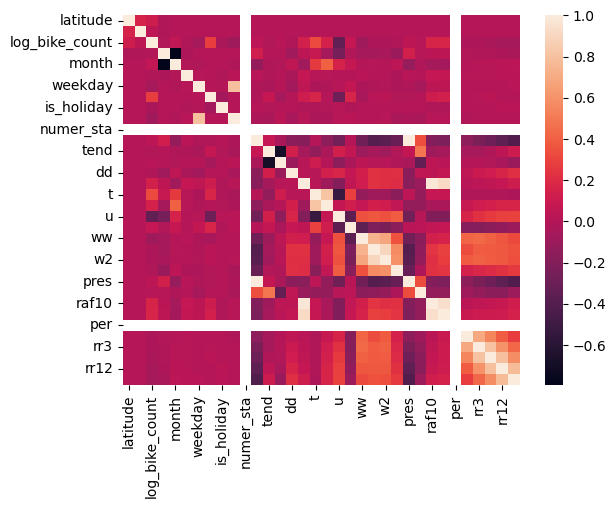

In [23]:
corr = data.select_dtypes('number').corr()
sns.heatmap(corr)

We don't see a lot of linear correlation between log_bike_count and the other features... However, we can see four strange white lines, probably indicating constant features. Let's investigate.

In [ ]:
const_columns = data.columns[data.nunique() == 1]
print("Constant features :", list(const_columns))

Constant features : ['numer_sta', 'per']


As expected, we have two constant feature. We can drop them now : 

In [25]:
data = data.drop(columns=const_columns)
data

,counter_id,date,coordinates,latitude,longitude,log_bike_count,year,month,day,weekday,...,nbas,pres,tend24,raf10,rafper,rr1,rr3,rr6,rr12,rr24
0,100007049-101007049,2020-09-01 01:00:00,"48.846028,2.375429",48.846028,2.375429,0.693147,2020,9,1,1,...,0.0,100960,120.0,2.4,3.1,0.0,0.0,0.0,0.0,0.0
1,100056226-103056226,2020-09-01 01:00:00,"48.830331,2.400551",48.830331,2.400551,0.693147,2020,9,1,1,...,0.0,100960,120.0,2.4,3.1,0.0,0.0,0.0,0.0,0.0
2,100047545-104047545,2020-09-01 01:00:00,"48.890457,2.368852",48.890457,2.368852,0.693147,2020,9,1,1,...,0.0,100960,120.0,2.4,3.1,0.0,0.0,0.0,0.0,0.0
3,100060178-102060178,2020-09-01 01:00:00,"48.84638,2.31529",48.846380,2.315290,3.091042,2020,9,1,1,...,0.0,100960,120.0,2.4,3.1,0.0,0.0,0.0,0.0,0.0
4,100056327-103056327,2020-09-01 01:00:00,"48.86461,2.40969",48.864610,2.409690,1.098612,2020,9,1,1,...,0.0,100960,120.0,2.4,3.1,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
496822,100057380-103057380,2021-09-09 23:00:00,"48.86462,2.31444",48.864620,2.314440,3.496508,2021,9,9,3,...,8.0,100190,100.0,3.4,3.4,0.0,0.0,0.0,0.6,0.6
496823,100047547-103047547,2021-09-09 23:00:00,"48.82636,2.30303",48.826360,2.303030,1.098612,2021,9,9,3,...,8.0,100190,100.0,3.4,3.4,0.0,0.0,0.0,0.6,0.6
496824,100047548-103047548,2021-09-09 23:00:00,"48.89141,2.38482",48.891410,2.384820,1.609438,2021,9,9,3,...,8.0,100190,100.0,3.4,3.4,0.0,0.0,0.0,0.6,0.6
496825,100042374-110042374,2021-09-09 23:00:00,"48.8484,2.27586",48.848400,2.275860,2.302585,2021,9,9,3,...,8.0,100190,100.0,3.4,3.4,0.0,0.0,0.0,0.6,0.6


Let's see our new heatmap

<Axes: >

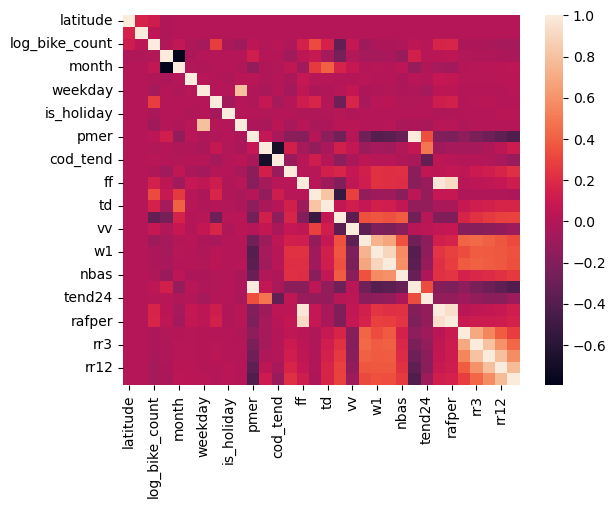

In [26]:
corr = data.select_dtypes('number').corr()
sns.heatmap(corr)